<a href="https://colab.research.google.com/github/pritkudale/Code_for_LinkedIn/blob/main/FAISS_Animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving animation... This might take a moment.
Animation saved successfully as vector_search_animation_v4.gif


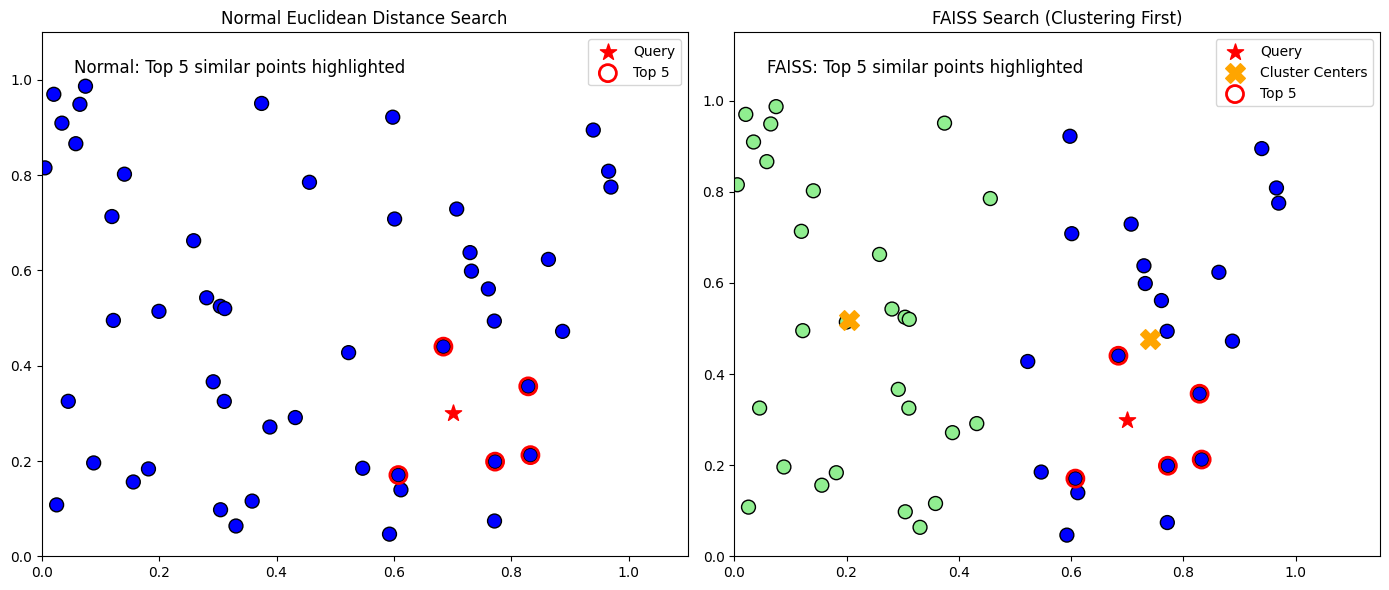

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.cluster import KMeans
from numpy.linalg import norm
import matplotlib.colors as mcolors

# Set random seed for reproducibility
np.random.seed(42)

# Generate random 2D vectors (data points)
n_points = 50
data = np.random.rand(n_points, 2)

# Define a fixed query point
query = np.array([0.7, 0.3])

# Function to compute Euclidean distance
def euclidean_distance(v, q):
    return norm(v - q)

# Pre-compute Euclidean distances
distances = np.array([euclidean_distance(point, query) for point in data])

# --- FAISS simulation --- #
k = 2
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
clusters = kmeans.fit_predict(data)
cluster_centers = kmeans.cluster_centers_

cluster_center_dists = np.array([euclidean_distance(center, query) for center in cluster_centers])
best_cluster = np.argmin(cluster_center_dists)
candidate_indices = np.where(clusters == best_cluster)[0]

# --- Animation parameters ---
n_frames_normal = n_points
n_frames_faiss_search = len(candidate_indices)
faiss_initial_delay = 2 # Frames for initial state
faiss_cluster_delay = 2 # Frames to show clusters
faiss_total_process_duration = faiss_initial_delay + faiss_cluster_delay + n_frames_faiss_search

process_frames = max(n_frames_normal, faiss_total_process_duration)
# Set extra_frames for ~2 second hold at interval=300ms (2000/300 ~ 7)
extra_frames = 7
total_frames = process_frames + extra_frames

top5_drawn_faiss = False
top5_drawn_normal = False
faiss_legend_drawn = False

fig, (ax_normal, ax_faiss) = plt.subplots(1, 2, figsize=(14, 6))

# --- Normal Search Plot Setup ---
ax_normal.set_title("Normal Euclidean Distance Search")
ax_normal.set_xlim(0, 1.1)
ax_normal.set_ylim(0, 1.1)
normal_initial_color = mcolors.to_rgba('lightgray')
# Persistent array for normal search colors (all start as lightgray)
global_normal_facecolors = np.tile(normal_initial_color, (n_points, 1))
normal_scatter = ax_normal.scatter(data[:, 0], data[:, 1], facecolors=global_normal_facecolors, s=100, edgecolor='k')
normal_query_scatter = ax_normal.scatter(query[0], query[1], c='red', s=150, marker='*', label='Query')
normal_legend = ax_normal.legend(handles=[normal_query_scatter], loc='upper right')
normal_line, = ax_normal.plot([], [], linestyle='--', color='black')
normal_text = ax_normal.text(0.05, 0.95, "", transform=ax_normal.transAxes, fontsize=12, verticalalignment='top')

# --- FAISS Plot Setup ---
ax_faiss.set_title("FAISS Search (Clustering First)")
ax_faiss.set_xlim(0, 1.15)
ax_faiss.set_ylim(0, 1.15)
faiss_initial_color = mcolors.to_rgba('lightgray')
cluster_color_names = ['skyblue', 'lightgreen']
faiss_cluster_colors_rgba = np.array([mcolors.to_rgba(cluster_color_names[c]) for c in clusters])
# Persistent array for FAISS search colors (starting with cluster colors)
global_faiss_facecolors = faiss_cluster_colors_rgba.copy()
faiss_scatter = ax_faiss.scatter(data[:, 0], data[:, 1], facecolors=global_faiss_facecolors, s=100, edgecolor='k')
faiss_centers_scatter = ax_faiss.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='orange', s=200, marker='X', label='Cluster Centers')
faiss_centers_scatter.set_visible(False)
faiss_query_scatter = ax_faiss.scatter(query[0], query[1], c='red', s=150, marker='*', label='Query')
faiss_legend = ax_faiss.legend(handles=[], labels=[], loc='upper right')
faiss_legend.set_visible(False)
faiss_line, = ax_faiss.plot([], [], linestyle='--', color='black')
faiss_text = ax_faiss.text(0.05, 0.95, "", transform=ax_faiss.transAxes, fontsize=12, verticalalignment='top')

normal_top5_handle = None
faiss_top5_handle = None

def update(frame):
    global top5_drawn_faiss, top5_drawn_normal, faiss_legend_drawn
    global faiss_legend, normal_legend, normal_top5_handle, faiss_top5_handle
    global global_normal_facecolors, global_faiss_facecolors

    # --- Normal Search Animation Logic ---
    normal_line.set_data([], [])
    if normal_top5_handle:
        normal_top5_handle.set_visible(False)

    if frame < n_frames_normal:
        # Mark the current point as processed (blue) and keep previous blue points.
        global_normal_facecolors[frame] = np.array([0, 0, 1, 1])
        normal_scatter.set_facecolors(global_normal_facecolors)
        current_point = data[frame]
        normal_line.set_data([query[0], current_point[0]], [query[1], current_point[1]])
        normal_text.set_text(f"Normal: Processing point {frame+1}/{n_points}")
        normal_legend.get_texts()[0].set_text('Query')
        normal_legend.legendHandles = [normal_query_scatter]
        normal_legend.set_visible(True)

    elif n_frames_normal <= frame < process_frames:
        # Intermediate phase: All points have been processed;
        # use the persistent colors (processed points remain blue).
        normal_scatter.set_facecolors(global_normal_facecolors)
        normal_line.set_data([], [])
        normal_text.set_text("Normal: All points processed")
        normal_legend.get_texts()[0].set_text('Query')
        normal_legend.legendHandles = [normal_query_scatter]
        normal_legend.set_visible(True)

    elif frame >= process_frames and not top5_drawn_normal:
        # Final Hold phase: Draw Top 5 for Normal Search once.
        normal_sorted_indices = np.argsort(distances)
        normal_top5 = normal_sorted_indices[:5]
        # Do not reset colors; maintain persistent blue for processed points.
        normal_scatter.set_facecolors(global_normal_facecolors)
        normal_top5_collection = ax_normal.scatter(data[normal_top5, 0], data[normal_top5, 1],
                                                   s=150, facecolors='none', edgecolors='red', linewidths=2, label='Top 5')
        normal_top5_handle = normal_top5_collection
        handles = [normal_query_scatter, normal_top5_handle]
        labels = ['Query', 'Top 5']
        normal_legend.legendHandles = handles
        for h, l in zip(normal_legend.legendHandles, labels):
            h.set_label(l)
        ax_normal.legend(handles=handles, labels=labels, loc='upper right')
        normal_legend = ax_normal.get_legend()
        normal_legend.set_visible(True)
        normal_text.set_text("Normal: Top 5 similar points highlighted")
        normal_line.set_data([], [])
        top5_drawn_normal = True

    elif frame >= process_frames:
        normal_text.set_text("Normal: Top 5 similar points highlighted")
        normal_scatter.set_facecolors(global_normal_facecolors)
        if normal_top5_handle:
            normal_top5_handle.set_visible(True)
            normal_legend.set_visible(True)
        normal_line.set_data([], [])

    # --- FAISS Animation Logic ---
    faiss_centers_scatter.set_visible(False)
    faiss_line.set_data([], [])
    if faiss_top5_handle:
        faiss_top5_handle.set_visible(False)
    faiss_legend.set_visible(False)

    if frame < faiss_initial_delay:
        faiss_scatter.set_facecolors(global_faiss_facecolors)
        faiss_text.set_text("FAISS: Initial State")
        faiss_centers_scatter.set_visible(False)

    elif frame < faiss_initial_delay + faiss_cluster_delay:
        faiss_scatter.set_facecolors(faiss_cluster_colors_rgba)
        faiss_centers_scatter.set_visible(True)
        faiss_text.set_text("FAISS: Clusters Identified")
        if not faiss_legend_drawn:
            handles = [faiss_query_scatter, faiss_centers_scatter]
            labels = ['Query', 'Cluster Centers']
            ax_faiss.legend(handles=handles, labels=labels, loc='upper right')
            faiss_legend = ax_faiss.get_legend()
            faiss_legend.set_visible(True)
            faiss_legend_drawn = True
        else:
            handles = [faiss_query_scatter, faiss_centers_scatter]
            labels = ['Query', 'Cluster Centers']
            ax_faiss.legend(handles=handles, labels=labels, loc='upper right')
            faiss_legend = ax_faiss.get_legend()
            faiss_legend.set_visible(True)

    elif frame < faiss_total_process_duration:
        candidate_frame_index = frame - (faiss_initial_delay + faiss_cluster_delay)
        candidate_idx = candidate_indices[candidate_frame_index]
        # Mark the candidate as processed (blue) in our persistent FAISS colors array.
        global_faiss_facecolors[candidate_idx] = np.array([0, 0, 1, 1])
        faiss_scatter.set_facecolors(global_faiss_facecolors)
        faiss_centers_scatter.set_visible(True)
        handles = [faiss_query_scatter, faiss_centers_scatter]
        labels = ['Query', 'Cluster Centers']
        ax_faiss.legend(handles=handles, labels=labels, loc='upper right')
        faiss_legend = ax_faiss.get_legend()
        faiss_legend.set_visible(True)
        current_candidate = data[candidate_idx]
        faiss_line.set_data([query[0], current_candidate[0]], [query[1], current_candidate[1]])
        faiss_text.set_text(f"FAISS: Processing candidate {candidate_frame_index+1}/{n_frames_faiss_search}")

    elif not top5_drawn_faiss:
        candidate_distances = distances[candidate_indices]
        sorted_candidate_order = np.argsort(candidate_distances)
        faiss_top5 = candidate_indices[sorted_candidate_order[:5]]
        # Do not reset colors; maintain persistent blue for processed candidates.
        faiss_scatter.set_facecolors(global_faiss_facecolors)
        faiss_centers_scatter.set_visible(True)
        faiss_top5_collection = ax_faiss.scatter(data[faiss_top5, 0], data[faiss_top5, 1],
                                                 s=150, facecolors='none', edgecolors='red', linewidths=2, label='Top 5')
        faiss_top5_handle = faiss_top5_collection
        handles = [faiss_query_scatter, faiss_centers_scatter, faiss_top5_handle]
        labels = ['Query', 'Cluster Centers', 'Top 5']
        ax_faiss.legend(handles=handles, labels=labels, loc='upper right')
        faiss_legend = ax_faiss.get_legend()
        faiss_legend.set_visible(True)
        faiss_text.set_text("FAISS: Top 5 similar points highlighted")
        faiss_line.set_data([], [])
        top5_drawn_faiss = True

    else:
        faiss_text.set_text("FAISS: Top 5 similar points highlighted")
        faiss_scatter.set_facecolors(global_faiss_facecolors)
        faiss_centers_scatter.set_visible(True)
        if faiss_top5_handle:
            faiss_top5_handle.set_visible(True)
        faiss_line.set_data([], [])
        if faiss_legend_drawn:
            handles = [faiss_query_scatter, faiss_centers_scatter, faiss_top5_handle] if faiss_top5_handle else [faiss_query_scatter, faiss_centers_scatter]
            labels = ['Query', 'Cluster Centers', 'Top 5'] if faiss_top5_handle else ['Query', 'Cluster Centers']
            ax_faiss.legend(handles=handles, labels=labels, loc='upper right')
            faiss_legend = ax_faiss.get_legend()
            faiss_legend.set_visible(True)

    artists = [normal_scatter, faiss_scatter, normal_line, faiss_line, normal_text, faiss_text, faiss_centers_scatter]
    if normal_top5_handle:
        artists.append(normal_top5_handle)
    if faiss_top5_handle:
        artists.append(faiss_top5_handle)
    return artists

# Create and save the animation
ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=300, blit=False, repeat=False)
print("Saving animation... This might take a moment.")
try:
    ani.save('vector_search_animation_v4.gif', writer='pillow')
    print("Animation saved successfully as vector_search_animation_v4.gif")
except Exception as e:
    print(f"Error saving animation: {e}")
plt.tight_layout()
plt.show()
